In [ ]:
!pip install ISLP
!pip install catboost

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=4f9e7490640d47feffb5257bb5158ba92c129d664024a22c9b3f84708c5784dc
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize)

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
(LinearDiscriminantAnalysis as LDA,
QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from itertools import combinations

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, balanced_accuracy_score,classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


In [ ]:
df = pd.read_csv("train.csv")
df.head(5)

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,1,67,0,3,0,37.205177,0,12.215677,7.780544,6.433890,...,1,0,6.009376,0,0,0,1,1,0,XXXConfid
1,2,65,1,0,0,35.141843,1,17.111404,6.645284,1.112379,...,0,0,7.519209,0,0,0,0,1,0,XXXConfid
2,3,62,0,1,1,17.875103,0,13.525546,9.585769,4.266008,...,0,0,8.573933,0,0,0,0,0,0,XXXConfid
3,4,67,0,0,1,37.503437,1,19.952014,1.953946,6.797333,...,0,0,6.217530,0,0,0,0,1,0,XXXConfid
4,5,65,1,0,2,29.187863,1,0.533209,8.759570,6.364302,...,1,0,5.193683,1,0,0,0,1,0,XXXConfid


**Exploratory Data Analysis (EDA)**

In [ ]:
#Checking for NULL values
df.isna().sum()

,0
PatientID,0
Age,0
Gender,0
Ethnicity,0
EducationLevel,0
BMI,0
Smoking,0
AlcoholConsumption,0
PhysicalActivity,0
DietQuality,0


In [ ]:
#Checking for duplicates
duplicates = df[df[list(df.columns)].duplicated()].index
duplicates

Index([], dtype='int64')

The dataset got no duplicates and no null values

In [ ]:
def reset_df():
    # 0.8-0.2 Train-val split
    df_train, df_val = train_test_split(df, test_size=0.2, random_state=5, stratify=df['Diagnosis'])

    train_diagnosis = df_train['Diagnosis'].reset_index(drop = True)
    val_diagnosis = df_val['Diagnosis'].reset_index(drop = True)

    #Dropping Irrelevant columns
    df_train = df_train.drop(['PatientID', 'DoctorInCharge','Diagnosis'], axis=1)
    df_val = df_val.drop(['PatientID', 'DoctorInCharge','Diagnosis'], axis=1)

    #Standardizing every column except diagnosis
    scaler = StandardScaler()

    df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
    df_val = pd.DataFrame(scaler.transform(df_val), columns = df_val.columns)

    #Adding diagnosis column which is not standardized
    df_train['Diagnosis'] = train_diagnosis
    df_val['Diagnosis'] = val_diagnosis
    return df_train, df_val, scaler
df_train, df_val, scaler = reset_df()

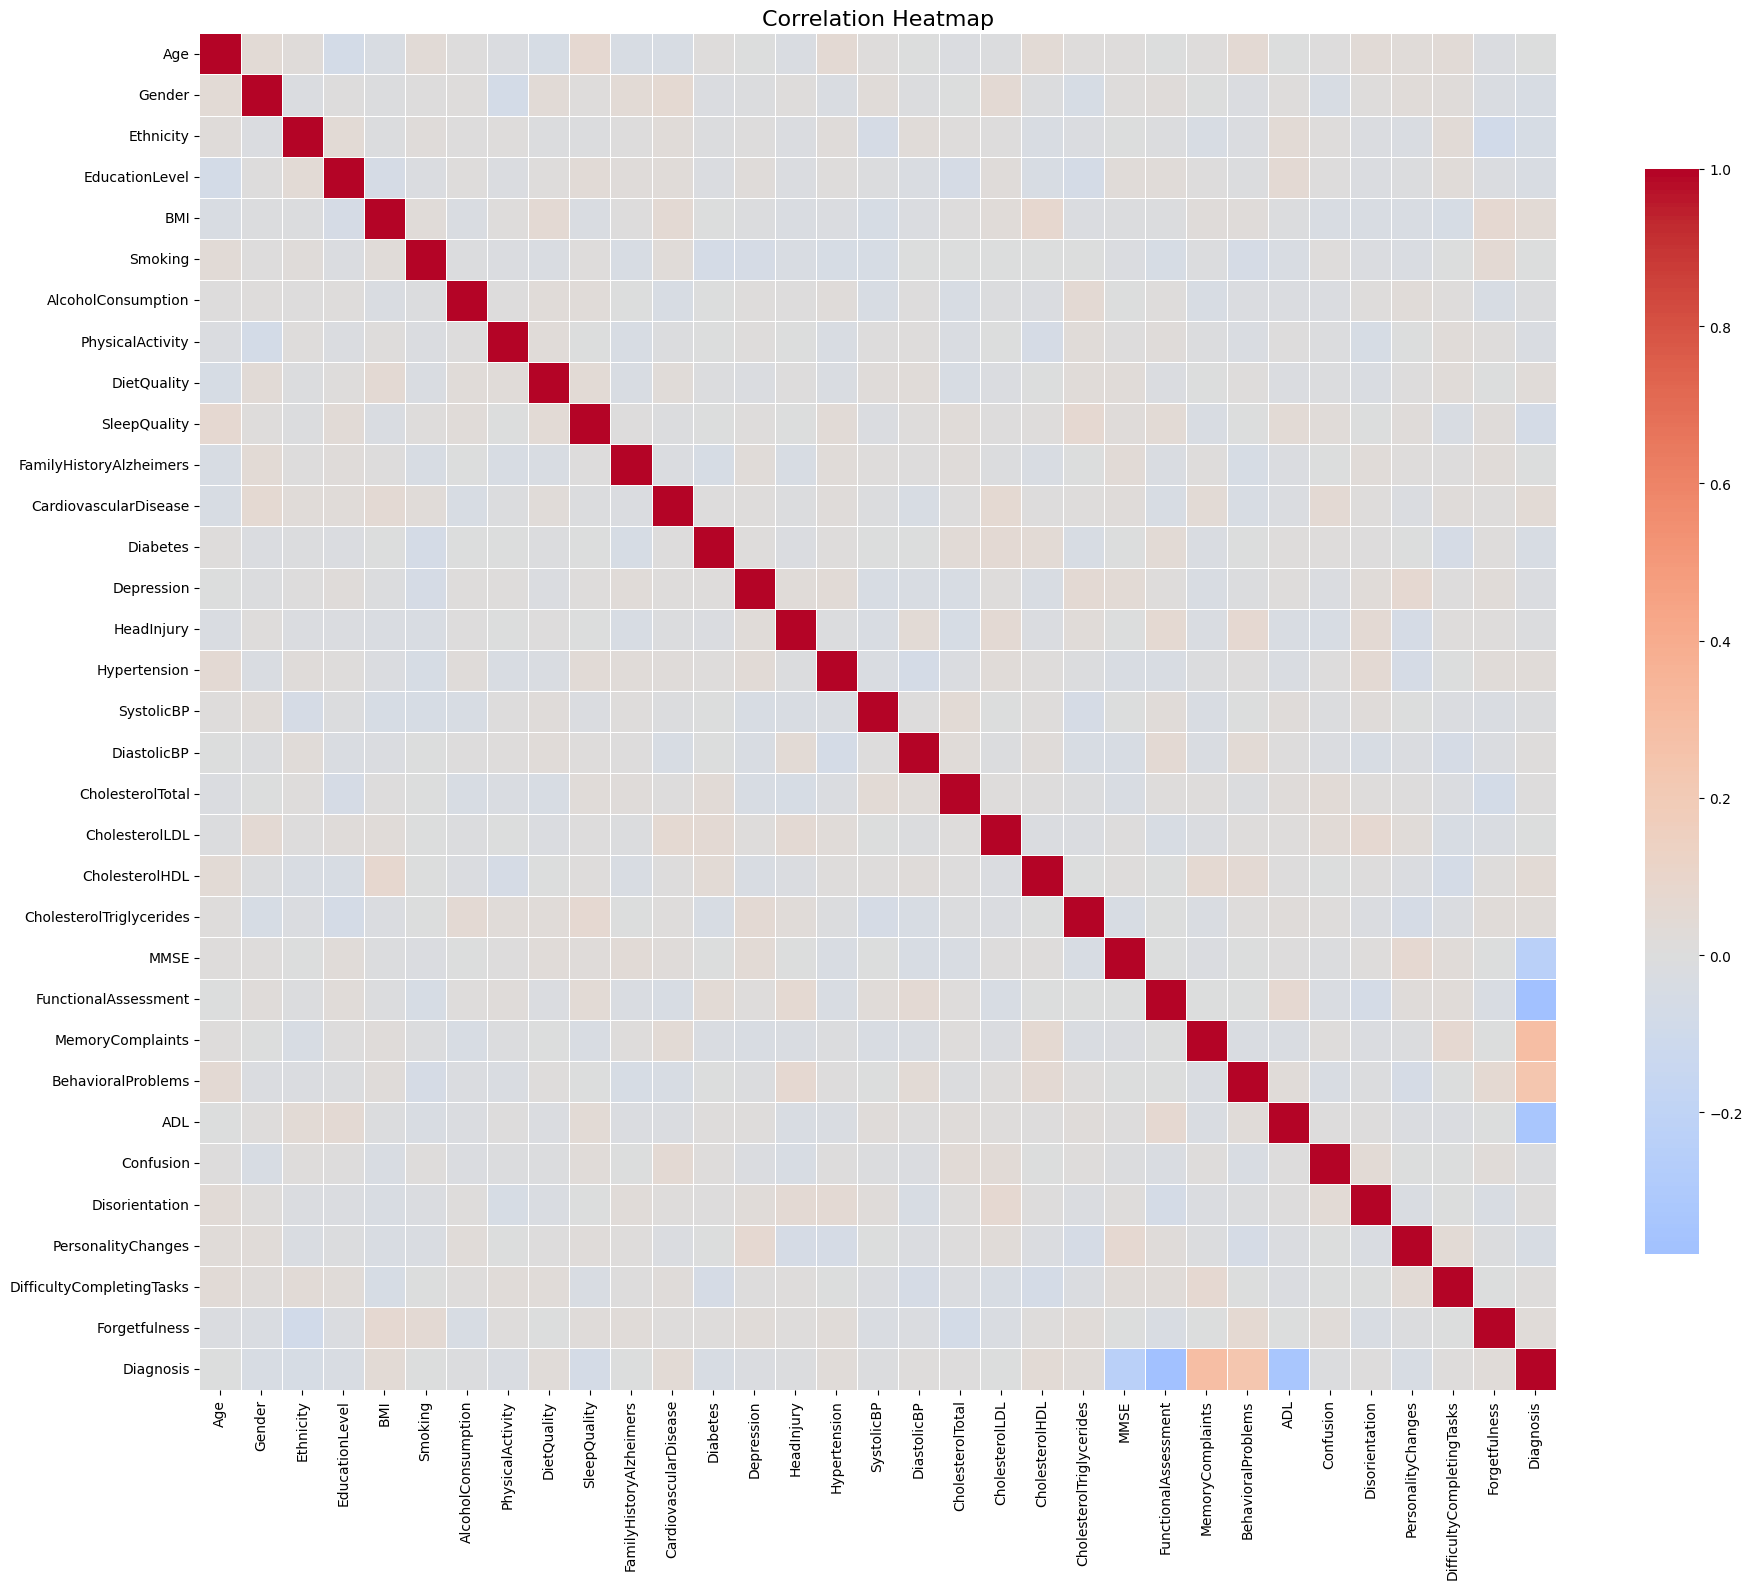

In [ ]:
#Plotting Correlation Matrix
correlation_matrix = df_train.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def top_correlated_features(data, target_feature, top_n=10):
    # Identifies the top correlated features to a given target feature.

    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Extract correlation values for the target feature
    target_correlation = correlation_matrix[target_feature].drop(labels=[target_feature])

    # Get the top N correlated features (absolute value to account for both positive and negative correlations)
    top_correlations = target_correlation.abs().sort_values(ascending=False).head(top_n)

    # Return the correlation values with original signs
    return target_correlation[top_correlations.index]
top_correlated_features(df_train,"BehavioralProblems")

,BehavioralProblems
Diagnosis,0.239710
HeadInjury,0.064203
PersonalityChanges,-0.060831
Forgetfulness,0.060083
Smoking,-0.058980
Age,0.054790
FamilyHistoryAlzheimers,-0.050267
CholesterolHDL,0.047882
CardiovascularDisease,-0.044209
DiastolicBP,0.041060


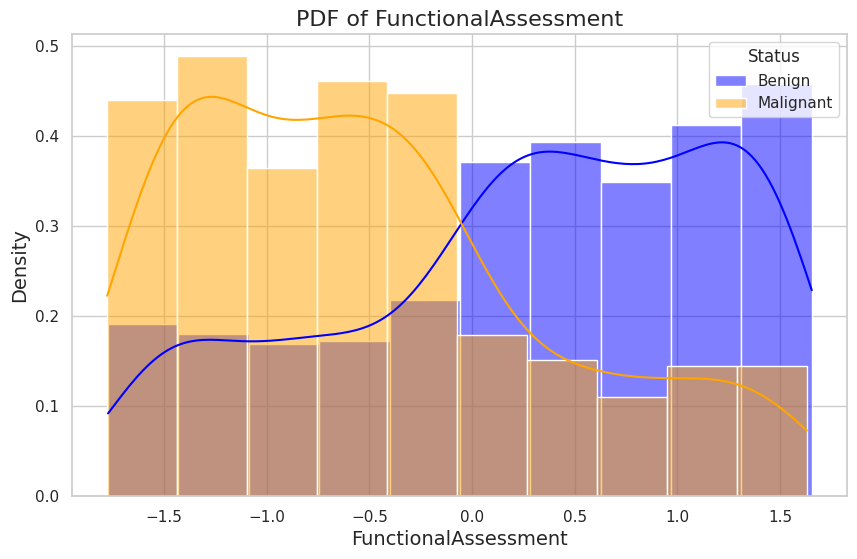

In [ ]:
def plot_pdf(df, col):
    #Plot two pdf: pdf of specific column given diagnosis = 0, pdf of specific column given diagnosis = 1
    sns.set(style="whitegrid")

    # Plot the PDF using Seaborn's kdeplot
    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['Diagnosis'] == 0][col], kde=True, color='blue', label='Benign', stat="density", bins=10, alpha=0.5)
    sns.histplot(df[df['Diagnosis'] == 1][col], kde=True, color='orange', label='Malignant', stat="density", bins=10, alpha=0.5)

    plt.title(f"PDF of {col}", fontsize=16)
    plt.xlabel(f"{col}", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(title="Status")
    plt.grid(True)

    plt.show()
plot_pdf(df_train,"FunctionalAssessment")

1. FunctionalAssessment > 0, tend to be Benign
   FunctionalAssessment < 0, tend to be Malignant
2. Graph overlaps, so additional features are needed to classify Benign/Malignant

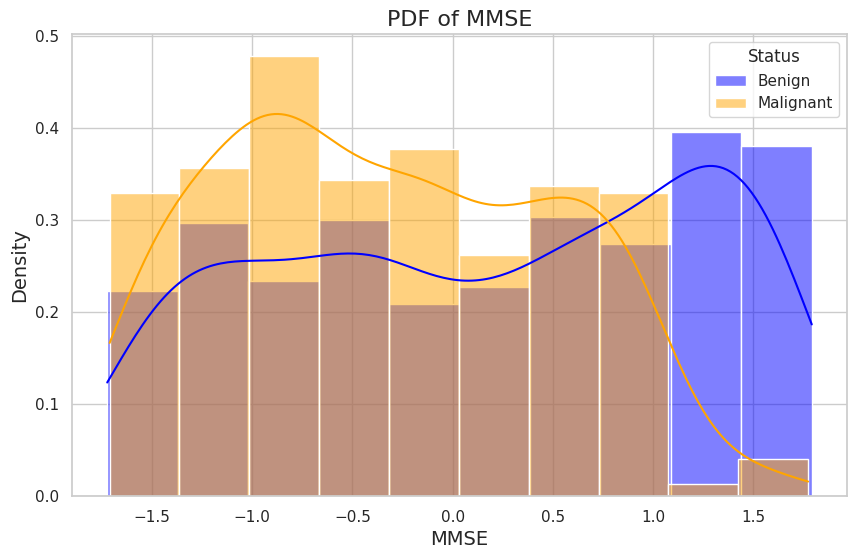

In [ ]:
plot_pdf(df_train,'MMSE')

<ipython-input-11-4e68a1b26e33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Diagnosis', y=col, palette={'0': 'blue', '1': 'orange'})


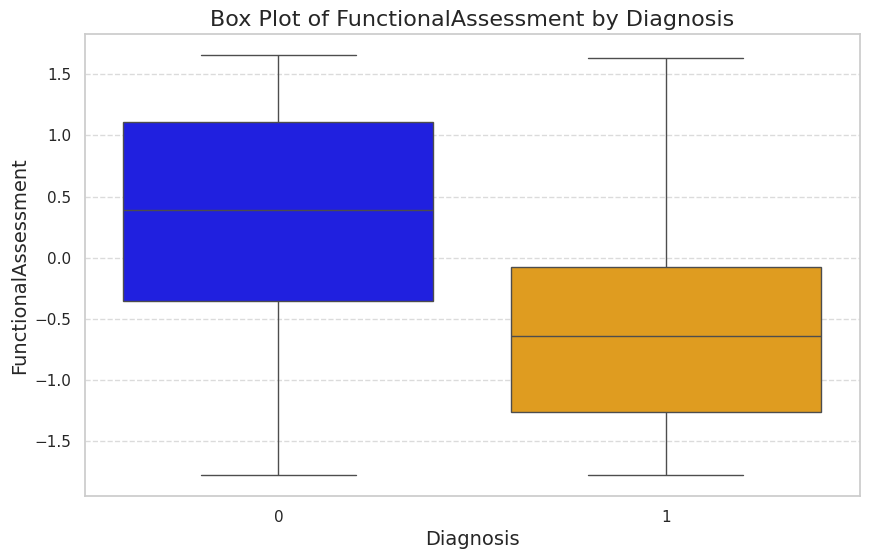

In [ ]:
def plot_box(df,col):
    #Plotting box plot of specific column for diagnosis = 0, diagnosis = 1

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='Diagnosis', y=col, palette={'0': 'blue', '1': 'orange'})

    plt.title(f'Box Plot of {col} by Diagnosis', fontsize=16)
    plt.xlabel('Diagnosis', fontsize=14)
    plt.ylabel(col, fontsize=14)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
plot_box(df_train,"FunctionalAssessment")

<ipython-input-11-4e68a1b26e33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Diagnosis', y=col, palette={'0': 'blue', '1': 'orange'})


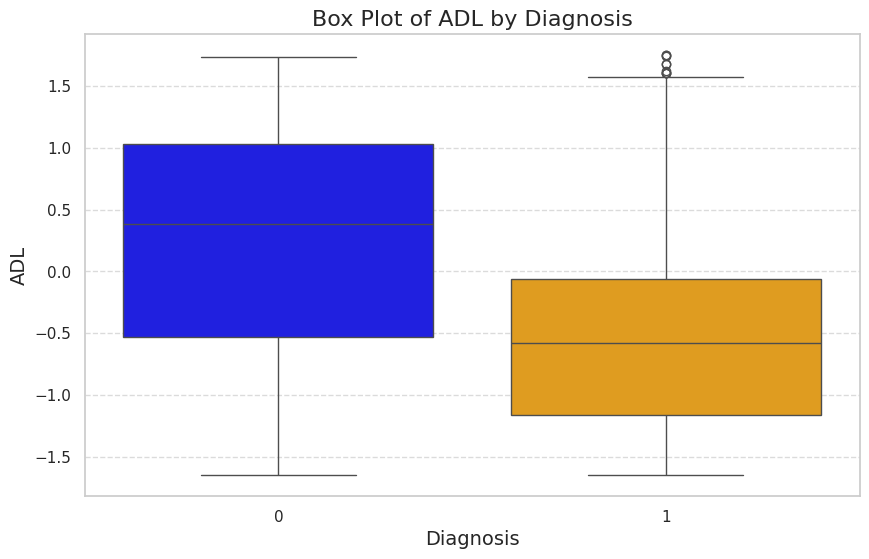

In [ ]:
plot_box(df_train,"ADL")

In [ ]:
#Finding upper bound for group 1
grouped = df_train.groupby('Diagnosis')['ADL']

# For Diagnosis = 1 (orange box)
Q1 = grouped.quantile(0.25).loc[1]
Q3 = grouped.quantile(0.75).loc[1]
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Print results for Diagnosis = 1
print("For Diagnosis = 1:")
print("Q1:", Q1)
print("Q3:", Q3)
print("IQR:", IQR)
print("Upper Bound:", upper_bound)


For Diagnosis = 1:
Q1: -1.1616764567839484
Q3: -0.059578148261666145
IQR: 1.1020983085222822
Upper Bound: 1.593569314521757


In [ ]:
len(df_train[(df_train['ADL'] > upper_bound) & (df_train['Diagnosis'] == 1)])


9

<ipython-input-11-4e68a1b26e33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Diagnosis', y=col, palette={'0': 'blue', '1': 'orange'})


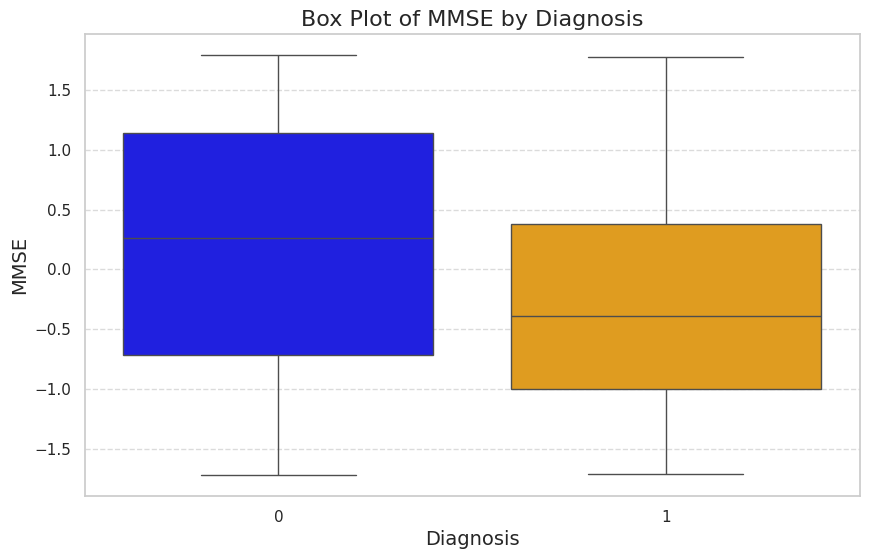

In [ ]:
plot_box(df_train,"MMSE")

<ipython-input-11-4e68a1b26e33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Diagnosis', y=col, palette={'0': 'blue', '1': 'orange'})


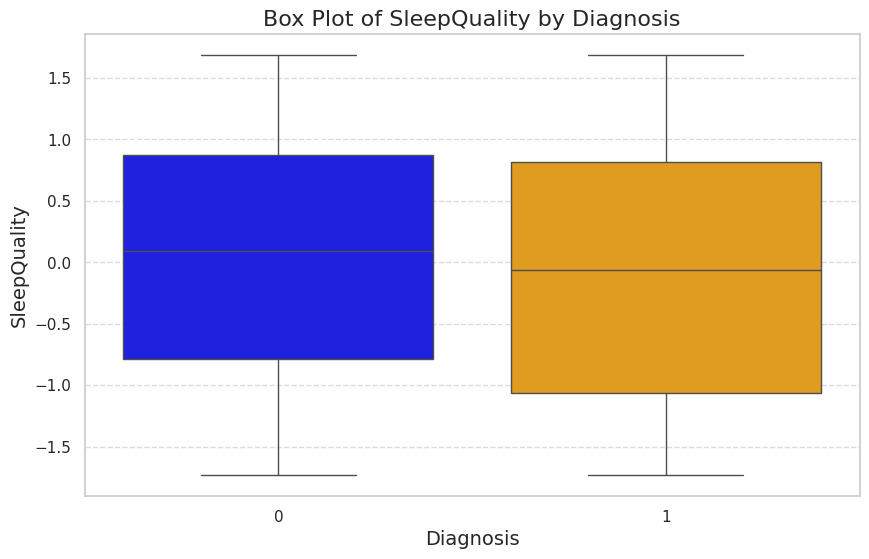

In [ ]:
plot_box(df_train,"SleepQuality")

Class Distribution:
Diagnosis
0    777
1    426
Name: count, dtype: int64


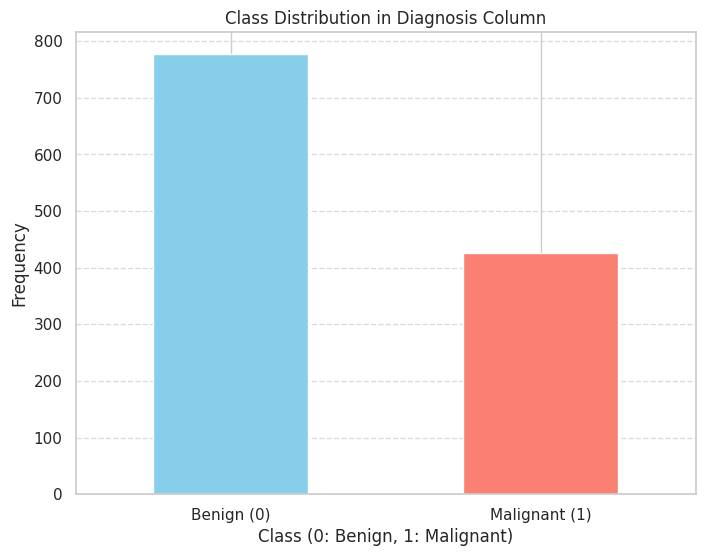

In [ ]:
class_counts = df_train['Diagnosis'].value_counts()

# Print the distribution
print("Class Distribution:")
print(class_counts)

# Plot the distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution in Diagnosis Column')
plt.xlabel('Class (0: Benign, 1: Malignant)')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Model**

In [ ]:
def evaluate(model, X, y, class_report = True):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y,y_pred)
    f1 = f1_score(y,y_pred, average='weighted')
    sensitivity = recall_score(y,y_pred,average='weighted')
    balanced_accuracy = balanced_accuracy_score(y,y_pred)
    if class_report:
        print(classification_report(y, y_pred, target_names=["Benign","Malignant"]))
    return accuracy, f1, sensitivity, balanced_accuracy

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val, class_report = True):
    train_accuracy, train_f1, train_sensitivity, train_balanced_accuracy = evaluate(model, X_train, y_train, class_report)
    validation_accuracy, validation_f1, validation_sensitivity, validation_balanced_accuracy = evaluate(model, X_val, y_val, class_report)
    print(f"Training Metrics: Accuracy = {train_accuracy}, F1 score = {train_f1}, Sensitivity = {train_sensitivity}")
    print(f"Validation Metrics: Accuracy = {validation_accuracy}, F1 score = {validation_f1}, Sensitivity = {validation_sensitivity}")

In [ ]:
def prepare_X_y(X_col, resample = True):
    #prepare X, y given arbitrary training features with SMOTE resampling
    X_train = df_train[X_col]
    y_train = df_train['Diagnosis']

    X_val = df_val[X_col]
    y_val = df_val['Diagnosis']

    #Apply SMOTE resampling
    if resample == True:
        smote = SMOTE(random_state=0)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    return X_train, y_train, X_val, y_val

Logistic Regression

In [ ]:
#Try using MMSE, FunctionalAssessment, MemoryComplaints, BehavioralProblems, ADL for fitting (5 most important features)
X_train, y_train, X_val, y_val = prepare_X_y(['MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL',])
lr_model = LogisticRegression(
    penalty='l2',  # L2 regularization (ridge)
    C=1.0,
    solver='liblinear',  # Good for small datasets
    random_state=42,
    max_iter=1000,
)

# Fit the model
lr_model.fit(X_train, y_train)
evaluate_model(lr_model, X_train, y_train, X_val, y_val)

              precision    recall  f1-score   support

      Benign       0.84      0.82      0.83       777
   Malignant       0.82      0.84      0.83       777

    accuracy                           0.83      1554
   macro avg       0.83      0.83      0.83      1554
weighted avg       0.83      0.83      0.83      1554

              precision    recall  f1-score   support

      Benign       0.88      0.80      0.84       195
   Malignant       0.69      0.80      0.74       106

    accuracy                           0.80       301
   macro avg       0.78      0.80      0.79       301
weighted avg       0.81      0.80      0.80       301

Training Metrics: Accuracy = 0.832046332046332, F1 score = 0.8320262301382366, Sensitivity = 0.832046332046332
Validation Metrics: Accuracy = 0.8006644518272426, F1 score = 0.803641904264886, Sensitivity = 0.8006644518272426


Decision Tree

In [ ]:
#Decision Tree
clf = DecisionTreeClassifier(random_state=0, max_depth = 5, min_samples_split = 2)
clf.fit(X_train, y_train)
evaluate_model(clf, X_train, y_train, X_val, y_val)

              precision    recall  f1-score   support

      Benign       0.95      0.98      0.97       777
   Malignant       0.98      0.95      0.96       777

    accuracy                           0.96      1554
   macro avg       0.96      0.96      0.96      1554
weighted avg       0.96      0.96      0.96      1554

              precision    recall  f1-score   support

      Benign       0.96      0.92      0.94       195
   Malignant       0.87      0.93      0.90       106

    accuracy                           0.93       301
   macro avg       0.92      0.93      0.92       301
weighted avg       0.93      0.93      0.93       301

Training Metrics: Accuracy = 0.9646074646074646, F1 score = 0.9646010002174386, Sensitivity = 0.9646074646074646
Validation Metrics: Accuracy = 0.9269102990033222, F1 score = 0.927473865474596, Sensitivity = 0.9269102990033222


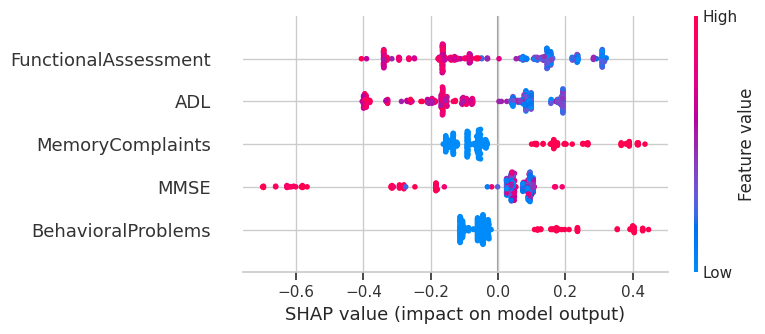

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(clf)

# Get SHAP values for the entire dataset
shap_values = explainer.shap_values(X_val)

# Visualize SHAP values
shap.summary_plot(shap_values[:,:,1], X_val)  # For binary classification (class 1)

Random Forest

In [ ]:
#Random Forest using all features & Grid search
features = [col for col in df_train.columns if col != 'Diagnosis']
X_train, y_train, X_val, y_val = prepare_X_y(features)

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['log2','sqrt'],
    'bootstrap': [True]
}

In [ ]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='precision', verbose=1) #Accuracy
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'max_depth': [None, 10],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='precision', verbose=1)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)
best_rf = grid_search.best_estimator_

Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy: 0.9760440649975571


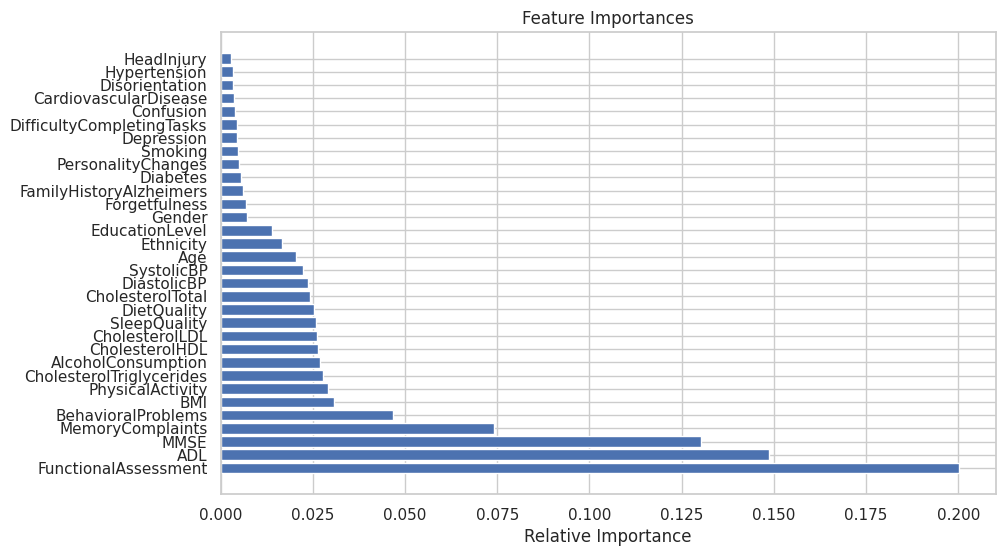

In [ ]:
#Feature importances from our Random Forest
importances = best_rf.feature_importances_

feature_names = X_train.columns

indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.xlabel("Relative Importance")
plt.show()

In [ ]:
validation_accuracy, validation_f1, validation_sensitivity, validation_balanced_accuracy = evaluate(best_rf, X_val, y_val)
print(f"Validation Metrics: Accuracy = {validation_accuracy}, F1 score = {validation_f1}, Sensitivity = {validation_sensitivity}")

              precision    recall  f1-score   support

      Benign       0.93      0.95      0.94       195
   Malignant       0.90      0.87      0.88       106

    accuracy                           0.92       301
   macro avg       0.92      0.91      0.91       301
weighted avg       0.92      0.92      0.92       301

Validation Metrics: Accuracy = 0.920265780730897, F1 score = 0.9199038477754095, Sensitivity = 0.920265780730897


XGBoost

In [ ]:
#Fitting XGBoost on 30 most important features
X_train, y_train, X_val, y_val = prepare_X_y(np.array(feature_names)[indices][:30])

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,  # Use all available cores
)

xgb_clf.fit(X_train,y_train)
evaluate_model(xgb_clf,X_train, y_train, X_val, y_val)

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       777
   Malignant       1.00      1.00      1.00       777

    accuracy                           1.00      1554
   macro avg       1.00      1.00      1.00      1554
weighted avg       1.00      1.00      1.00      1554

              precision    recall  f1-score   support

      Benign       0.97      0.93      0.95       195
   Malignant       0.88      0.94      0.91       106

    accuracy                           0.93       301
   macro avg       0.92      0.94      0.93       301
weighted avg       0.94      0.93      0.93       301

Training Metrics: Accuracy = 1.0, F1 score = 1.0, Sensitivity = 1.0
Validation Metrics: Accuracy = 0.9335548172757475, F1 score = 0.9340671504314509, Sensitivity = 0.9335548172757475


In [ ]:
#XGBoost with grid search
param_grid = {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 1],
              'max_depth': [3, 5, 7],
              }
# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='precision', verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='precision', verbose=1)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)
best_xgb = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Best Accuracy: 0.9735702856249894


In [ ]:
validation_accuracy, validation_f1, validation_sensitivity, validation_balanced_accuracy = evaluate(best_xgb, X_val, y_val)
print(f"Validation Metrics: Accuracy = {validation_accuracy}, F1 score = {validation_f1}, Sensitivity = {validation_sensitivity}")

              precision    recall  f1-score   support

      Benign       0.96      0.95      0.95       195
   Malignant       0.91      0.92      0.92       106

    accuracy                           0.94       301
   macro avg       0.93      0.94      0.93       301
weighted avg       0.94      0.94      0.94       301

Validation Metrics: Accuracy = 0.9401993355481728, F1 score = 0.9403246524815795, Sensitivity = 0.9401993355481728


In [ ]:
#SKlearn gradient boosting + Grid search
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state = 0)

grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'precision')
grid_search.fit(X_train,y_train)
best_gb = grid_search.best_estimator_

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Best Accuracy: 0.9643439784819096


In [ ]:
validation_accuracy, validation_f1, validation_sensitivity, validation_balanced_accuracy = evaluate(best_gb, X_val, y_val)
print(f"Validation Metrics: Accuracy = {validation_accuracy}, F1 score = {validation_f1}, Sensitivity = {validation_sensitivity}")

              precision    recall  f1-score   support

      Benign       0.96      0.93      0.94       195
   Malignant       0.88      0.92      0.90       106

    accuracy                           0.93       301
   macro avg       0.92      0.93      0.92       301
weighted avg       0.93      0.93      0.93       301

Validation Metrics: Accuracy = 0.9269102990033222, F1 score = 0.9273451072876345, Sensitivity = 0.9269102990033222


In [ ]:
#CatBoost + Gridsearch
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(verbose=0)
grid_search = GridSearchCV(estimator=cbc, param_grid=param_grid, cv=5, scoring='precision', verbose=1)

grid_search.fit(X_train,y_train)
best_cbc = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Gridsearch Visualization（Edited）

    param_learning_rate  param_max_depth  param_n_estimators  mean_test_score
0                  0.01                3                  50         0.965752
1                  0.01                3                 100         0.968102
2                  0.01                3                 200         0.969561
3                  0.01                5                  50         0.970811
4                  0.01                5                 100         0.971982
5                  0.01                5                 200         0.973323
6                  0.01                7                  50         0.969303
7                  0.01                7                 100         0.968049
8                  0.01                7                 200         0.970737
9                  0.10                3                  50         0.966932
10                 0.10                3                 100         0.968125
11                 0.10                3                 200    

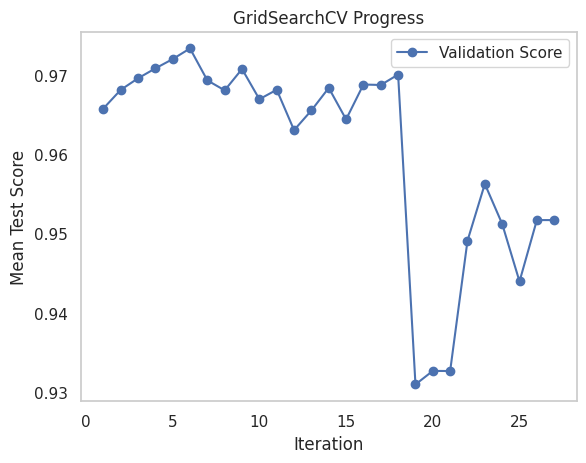

In [ ]:
# taking results
results = grid_search.cv_results_

# checking result tables
results_df = pd.DataFrame(results)
print(results_df[['param_learning_rate', 'param_max_depth','param_n_estimators', 'mean_test_score']])

# compute score
scores = results['mean_test_score']
iterations = range(1, len(scores) + 1)

# line graph
plt.plot(iterations, scores, marker='o', label='Validation Score')
plt.xlabel('Iteration')
plt.ylabel('Mean Test Score')
plt.title('GridSearchCV Progress')
plt.grid()
plt.legend()
plt.show()

Learning curve (Edited)


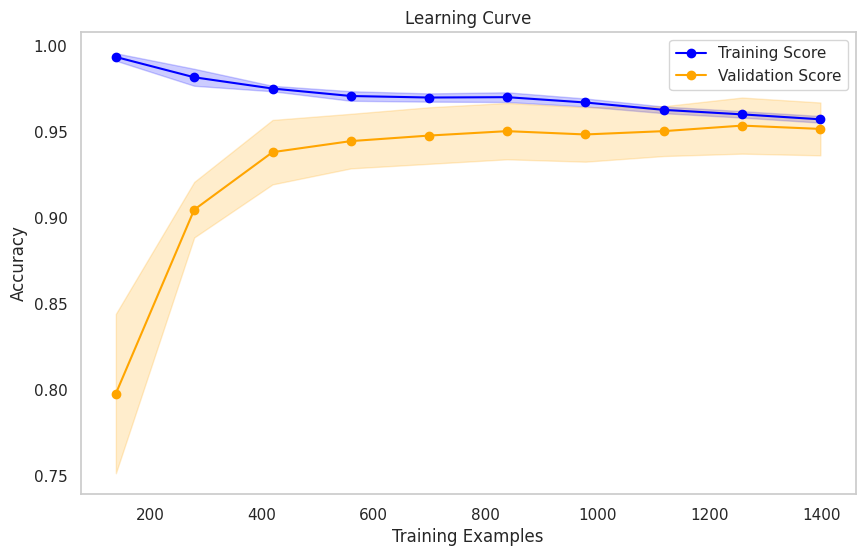

In [ ]:
from sklearn.model_selection import learning_curve
# define model
model = CatBoostClassifier(**best_cbc.get_params())

# calculating learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation Score')

# std area
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')


plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best Accuracy: 0.9733232763028855


In [ ]:
validation_accuracy, validation_f1, validation_sensitivity, validation_balanced_accuracy = evaluate(best_cbc, X_val, y_val)
print(f"Validation Metrics: Accuracy = {validation_accuracy}, F1 score = {validation_f1}, Sensitivity = {validation_sensitivity}")

              precision    recall  f1-score   support

      Benign       0.97      0.95      0.96       195
   Malignant       0.91      0.94      0.93       106

    accuracy                           0.95       301
   macro avg       0.94      0.95      0.94       301
weighted avg       0.95      0.95      0.95       301

Validation Metrics: Accuracy = 0.946843853820598, F1 score = 0.9470606199127708, Sensitivity = 0.946843853820598


Confusion Matrix and AUC (Edited)

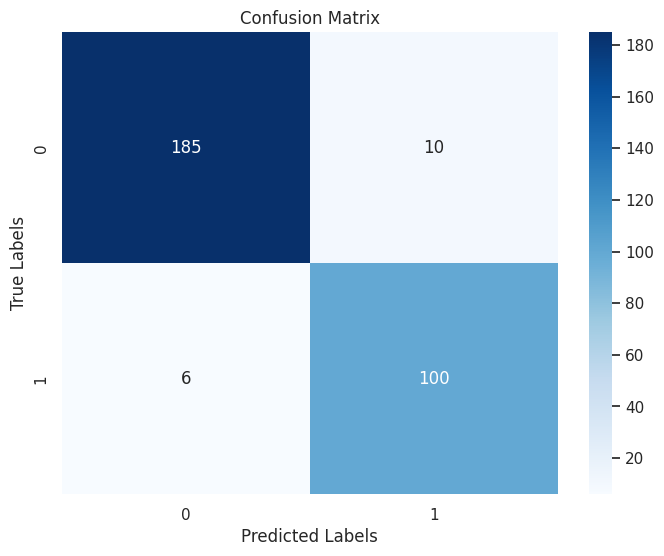

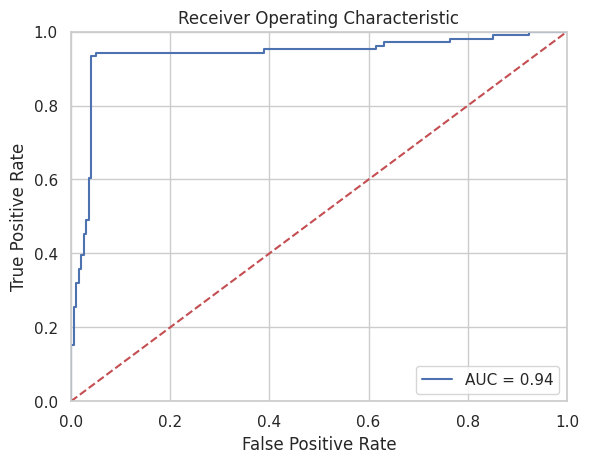

In [ ]:
#addded for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = y_val
y_pred = best_cbc.predict(X_val)

#compute
cm = confusion_matrix(y_true, y_pred)

#display
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#AUC
import sklearn.metrics as metrics
probs = best_cbc.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_true, preds)
roc_auc = metrics.auc(fpr, tpr)

#method: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Refitting the model on whole data

#Top 30 features
features = list(X_train.columns)

diag = df['Diagnosis'].reset_index(drop = True)

#Drop Irrelevant Columns
df_scaled = df.drop(['PatientID', 'DoctorInCharge','Diagnosis'], axis=1)

#Standardizing every column except diagnosis
df_scaled = pd.DataFrame(scaler.transform(df_scaled), columns=df_scaled.columns)

#Adding unscaled diagnosis column back
df_scaled['Diagnosis'] = diag

#Get X,y
X = df_scaled[features]
y = df_scaled['Diagnosis']
smote = SMOTE(random_state=20)

#Resample
X, y = smote.fit_resample(X, y)

#Refit the model on whole data
best_model = CatBoostClassifier(**best_cbc.get_params())
best_model.fit(X, y)

Ensembling

In [ ]:
X_train, y_train, X_val, y_val = prepare_X_y(['MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL',])

#Logistic regression
lr_pred = lr_model.predict_proba(X_val)

#Decision Tree
dt_pred = clf.predict_proba(X_val)

#Random Forest
features = [col for col in df_train.columns if col != 'Diagnosis']
X_train, y_train, X_val, y_val = prepare_X_y(features)

rf_pred = best_rf.predict_proba(X_val)

#Tree Boosting
X_train, y_train, X_val, y_val = prepare_X_y(np.array(feature_names)[indices][:30])
xgb_pred = best_xgb.predict_proba(X_val)
gb_pred = best_gb.predict_proba(X_val)
cbc_pred = best_cbc.predict_proba(X_val)

In [ ]:
#Weighted Averaging
y_pred_prob = (0.05*lr_pred + 0.05*dt_pred + 0.2*rf_pred + 0.2*xgb_pred + 0.2*gb_pred + 0.3*cbc_pred)
y_pred = np.argmax(y_pred_prob, axis=1)
print(f"Accuracy: {accuracy_score(y_val,y_pred)}")
print(f"Recall: {recall_score(y_val,y_pred, average='weighted')}")


Accuracy: 0.9435215946843853
Recall: 0.9435215946843853


**Model Submission**

In [ ]:
df_bf = pd.read_csv('best_submission.csv')
df_test = pd.read_csv("test.csv")


In [ ]:
def get_submission(model, features_used,scaler):
    df_test = pd.read_csv("test.csv")
    pat_ID = pd.DataFrame(df_test['PatientID'])
    df_test = df_test.drop(['PatientID', 'DoctorInCharge'], axis=1)
    df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

    X_t = df_test[features_used]
    y_test_pred = model.predict(X_t)
    pat_ID['Diagnosis'] = y_test_pred
    pat_ID.to_csv('submission.csv', index=False)

    accuracy, f1, sensitivity, _ = evaluate(model, X_t, df_bf['Diagnosis'])
    print(f"Comparing best result: Accuracy = {accuracy}, F1 score = {f1}, Sensitivity = {sensitivity}")

    print("Submission File Downloaded")

In [ ]:
get_submission(best_model, list(X_train.columns), scaler)

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       426
   Malignant       1.00      1.00      1.00       219

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645

Comparing best result: Accuracy = 1.0, F1 score = 1.0, Sensitivity = 1.0
Submission File Downloaded


In [ ]:
%%shell
jupyter nbconvert --to html /content/STA314_Project.ipynb

[NbConvertApp] Converting notebook /content/STA314_Project.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 1368585 bytes to /content/STA314_Project.html
